In [11]:
import sys
%load_ext autoreload
%autoreload 2
sys.path.append("../base")
sys.path.append("../data_provider")
sys.path.append("../models")
from common import *
from data_provider import DataProvider
from predictor import Predictor
import simple_linear_regression as simple_lr
import lasso_linear_regression as lasso_lr
import ridge_linear_regression as ridge_lr

data_provider = DataProvider()
x_train = data_provider.x_train
y_train = data_provider.y_train
x_control_test = data_provider.x_control_test
y_raw = data_provider.y_control_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
def test_ridge_model():
    train_predictions = []
    x_control_test = data_provider.x_control_test
    for i in range(10):
        predictor = Predictor(ridge_lr.build_model(), data_provider)
        prediction = predictor.predict(x_control_test[i : i + 1])[0]
        train_predictions.append(predictor.predict(x_control_test[i : i + 1])[0])
        if i % 10 == 0:
            print("processed", i, "/", len(x_control_test))
    print("all data processed. processing predictions.")
    train_predictions = data_provider.process_prediction(train_predictions)
    print("train mape score:", mape_score(y_raw[:len(train_predictions)], train_predictions))
    print("finished")
    answer_file = open("result.csv", "w")
    answer_file.write("Id,Price\n")
    for i in range(len(train_predictions)):
        answer_file.write("%s,%s\n" % (i + 1, train_predictions[i]))
    
test_ridge_model()

processed 0 / 6613
all data processed. processing predictions.
loss_value: 0.13541111405305142 index: 5
loss_value: 0.10124685770365713 index: 6
loss_value: 0.24944310583217147 index: 7
loss_value: 0.23321678371324533 index: 9
bad_cnt: 4
train mape score: 10.424309508191765
finished


../base/common.py:29: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  for i in range(len(y_data.as_matrix())):
../base/common.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  loss_value = np.abs((2 ** y_data.as_matrix()[i][0] - 2 ** prediction[i]) / (2 **
../base/common.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_data.as_matrix()[i][0]))
/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


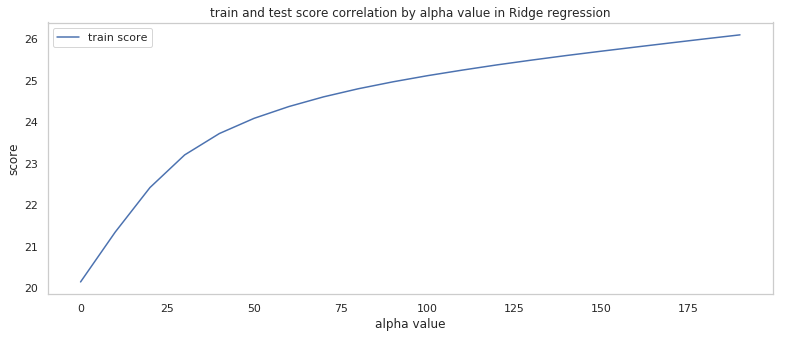

In [9]:
def draw_ridge_alpha_correlation():
    scores_train = []
    scores_test = []
    alpha_values = np.arange(0.001, 200, 10)
    for alpha_value in alpha_values:
        regression = ridge_lr.build_model_with_custom_alpha(alpha=alpha_value)
        regression.fit(x_train, y_train)
        train_prediction = regression.predict(x_train)
        scores_train.append(mape_score(y_train, train_prediction))
        
    f, (ax2) = plt.subplots(1, 1, figsize=(13, 5))

    ax2.plot(alpha_values, scores_train, label=u"train score")
    ax2.set_title(u"train and test score correlation by alpha value in Ridge regression")
    ax2.set_xlabel(u"alpha value")
    ax2.set_ylabel(u"score")
    ax2.grid()
    ax2.legend()

    f.show()    
draw_ridge_alpha_correlation()

In [ ]:
def draw_ridge_alpha_correlation():
    scores_train = []
    scores_test = []
    alpha_values = np.arange(0.001, 200, 10)
    for alpha_value in alpha_values:
        regression = lasso_lr.build_model_with_custom_alpha(alpha=alpha_value)
        regression.fit(x_train, y_train)
        train_prediction = regression.predict(x_train)
        scores_train.append(mape_score(y_train, train_prediction))
        
    f, (ax2) = plt.subplots(1, 1, figsize=(13, 5))

    ax2.plot(alpha_values, scores_train, label=u"train score")
    ax2.set_title(u"train and test score correlation by alpha value in Ridge regression")
    ax2.set_xlabel(u"alpha value")
    ax2.set_ylabel(u"score")
    ax2.grid()
    ax2.legend()

    f.show()    
draw_ridge_alpha_correlation()

In [17]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, \
    Normalizer, FunctionTransformer, RobustScaler, QuantileTransformer
import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rf
from datetime import datetime as dt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

answer_file = open("result.csv", "w")
answer_file.write("Id,Price\n")

train_predictions = []
for i in range(50):
    test_data = x_control_test[i : i + 1]
    test_data = test_data.dropna(axis = 'columns')
    columns = list(test_data.columns.values)
    x_train, y_train = data_provider.train_data_by_columns(columns)

    columns_to_drop = []
    for column in test_data.columns.values:
        if not column in x_train.columns.values:
            columns_to_drop.append(column)
    test_data = test_data.drop(columns = columns_to_drop)

    columns_to_drop = []
    for column in x_train.columns.values:
        if not column in test_data.columns.values:
            columns_to_drop.append(column)
    x_train = x_train.drop(columns = columns_to_drop)
    
    param_grid = {
    }

    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        #('polynomial', PolynomialFeatures()),
        #('drop_zeros', FunctionTransformer(drop_zeros)),
        ('cl', RidgeCV())
    ])

    grid_searcher = GridSearchCV(pipeline, param_grid=param_grid)
    grid_searcher.fit(x_train, y_train)
    prediction = data_provider.process_prediction(grid_searcher.predict(test_data))
    train_predictions.append(prediction)
    answer_file.write("%s,%s\n" % (i + 1, prediction))
    if i % 2 == 0:
        print("processed", i, "/", len(x_control_test))
print("train mape score:", mape_score(y_raw[:len(train_predictions)], train_predictions))

processed 0 / 6613
processed 2 / 6613
processed 4 / 6613
processed 6 / 6613
processed 8 / 6613
processed 10 / 6613
processed 12 / 6613
processed 14 / 6613
processed 16 / 6613
processed 18 / 6613
processed 20 / 6613
processed 22 / 6613
processed 24 / 6613
processed 26 / 6613
processed 28 / 6613
processed 30 / 6613
processed 32 / 6613
processed 34 / 6613
processed 36 / 6613
processed 38 / 6613
processed 40 / 6613
processed 42 / 6613
processed 44 / 6613
processed 46 / 6613
processed 48 / 6613
loss_value: [[0.1145]] index: 5
loss_value: [[0.11787365]] index: 6
loss_value: [[0.21463415]] index: 7
loss_value: [[0.08669109]] index: 8
loss_value: [[0.25126904]] index: 9
loss_value: [[0.12]] index: 12
loss_value: [[0.15767263]] index: 13
loss_value: [[0.16359447]] index: 16
loss_value: [[0.615]] index: 18
loss_value: [[0.1374026]] index: 19
loss_value: [[0.19305311]] index: 20
loss_value: [[0.10598726]] index: 21
loss_value: [[0.10000154]] index: 22
loss_value: [[0.10679612]] index: 23
loss_val